In [1]:
import pandas as pd
import os
from caveclient import CAVEclient
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from nglui.statebuilder import *
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [2]:
# initialize access to CAVE to access dataset 

client = CAVEclient()
3
if not os.path.isfile(os.path.expanduser("~/.cloudvolume/secrets/cave-secret.json")):
    client.auth.get_new_token(open=True)

datastack_name = 'fanc_production_mar2021'

client = CAVEclient(datastack_name)

In [3]:
# access CAVE annotation tables and import information on neurons of interest as a dataframe

feco_df_all = client.materialize.query_table('feco_axons_v0')
t1l_club_df = feco_df_all[(feco_df_all.cell_type.str.contains('club')) & (feco_df_all.classification_system == 'T1L')]
t2r_club_df = feco_df_all[(feco_df_all.cell_type.str.contains('club')) & (feco_df_all.classification_system == 'T2R')]

downstream_feco_df_all = client.materialize.query_table('downstream_feco_axons_v1')
downstream_10b_df_all = client.materialize.query_table('downstream_10b_table_v0')

In [4]:
# query upstream/downstream partners and make dataframe of neurons of interest and synapses 

upstream = False
syn_thresh = 4

# input t1l_clubs 
inputs = t1l_club_df.pt_root_id.tolist()
if upstream == True:
    syn_df = client.materialize.synapse_query(post_ids = inputs)
else:
    syn_df = client.materialize.synapse_query(pre_ids = inputs)
    
# filter out connections with <4 synapses 
from my_functions import *
t1l_synapse_df = filt_syn_df(syn_df, syn_thresh)


# input t2r_clubs 
inputs = t2r_club_df.pt_root_id.tolist()
if upstream == True:
    syn_df = client.materialize.synapse_query(post_ids = inputs)
else:
    syn_df = client.materialize.synapse_query(pre_ids = inputs)
    
# filter out connections with <4 synapses 
from my_functions import *
t2r_synapse_df = filt_syn_df(syn_df, syn_thresh)



In [5]:
# functions for applying cosine similarity to synapse dataframes 

def create_connectivity_matrix(int_ids, df_store):
    connectivity_mat = np.zeros((len(df_store), len(int_ids)))
    for i in range(len(int_ids)):
        for j in range(len(df_store)):
            if int_ids[i] in df_store[j]['post_pt_root_id'].values:
                curr_ids = df_store[j]['post_pt_root_id'].values
                connectivity_mat[j,i] = df_store[j]['number_of_synapses'][curr_ids == int_ids[i]].values[0]
    return connectivity_mat

def get_networkx_graph(syn_df, source = 'pre_pt_root_id', 
                       target = 'post_pt_root_id', edge_attr = 'count',
                       has_soma=True,
                       soma_table = 'somas_dec2022'):
    
    client = CAVEclient()
    dataset = 'fanc_production_mar2021'
    client = CAVEclient(dataset)

    soma_df = client.materialize.query_table(soma_table)
    edge_df = syn_df.groupby([source, target]).size().sort_values(ascending=False).reset_index(name=edge_attr)
    
    if has_soma ==True:       
        edge_df['has_soma'] = edge_df[target].isin(soma_df.pt_root_id)
        edge_df = edge_df.query('has_soma==True')
        
    graph = nx.from_pandas_edgelist(edge_df, source=source, 
                                  target=target, edge_attr=edge_attr)
    return graph

def get_edge_df(syn_df, source = 'pre_pt_root_id', 
                target = 'post_pt_root_id', edge_attr = 'count',
                soma_table = 'somas_dec2022'):
    client = CAVEclient()
    dataset = 'fanc_production_mar2021'
    client = CAVEclient(dataset)

    soma_df  =client.materialize.query_table(soma_table)
    edge_df = syn_df.groupby([source, target]).size().sort_values(ascending=False).reset_index(name=edge_attr)
    edge_df['has_soma'] = edge_df[target].isin(soma_df.pt_root_id)
    
    return edge_df

def get_asymm_conn_mat(syn_df, has_soma = True, weight='count', soma_table = 'somas_dec2022'):
    g = get_networkx_graph(syn_df, has_soma=has_soma, edge_attr=weight)
    
    edge_df = get_edge_df(syn_df, soma_table=soma_table, edge_attr=weight)
    
    targets = list(edge_df.post_pt_root_id.unique())
    sources = list(edge_df.pre_pt_root_id.unique())
    
    # Get indices for g.nodes indicating which node IDs are sources and which are targets
    source_ix, target_ix = [], []
    source_ids, target_ids = [], []
    for ix, i in enumerate(g.nodes()):
        if i in sources:
            source_ix.append(ix) 
            source_ids.append(i) 
        if i in targets:
            target_ix.append(ix)
            target_ids.append(i)

    conn_mat = nx.to_numpy_matrix(g, weight=weight) # Full connectivity matrix
#     conn_mat = nx.DiGraph(g, weight=weight)
    asymm_conn_mat = conn_mat[source_ix,:]
    asymm_conn_mat = asymm_conn_mat[:,target_ix]
    
    return asymm_conn_mat, source_ids, target_ids

def get_clustered_order(sim_mat, distance_threshold = 0, 
                       n_clusters = None, **kwargs):
    
    model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None).fit(sim_mat)
    #create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  #leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    #plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    dend_dict = dendrogram(linkage_matrix, **kwargs)
    
    #sorted order of indices found through clustering
    clustered_order = dend_dict['ivl']
    
    parsed_order = []
    for c in clustered_order:
        if '(' in c:
            c = c.split('(')[1]
            c = c.split(')')[0]
        parsed_order.append(int(c))
    
    return parsed_order

def get_sim_matrix(syn_df, asymmetric = True, weight='count', has_soma = True):
    
    #get weighted connectivity matrix from networkx graph
    if asymmetric:
        conn_mat, sources, targets = get_asymm_conn_mat(syn_df, has_soma = has_soma, weight=weight)
    else:
        g = get_networkx_graph(syn_df, has_soma = has_soma, edge_attr=weight)
        conn_mat = nx.to_numpy_matrix(g, weight=weight)
     
    conn_mat = np.asarray(conn_mat) #np.matrix usage is deprecated; convert to np.array

    #calculate cosine similarity
    sim_mat = cosine_similarity(conn_mat)
    
    return conn_mat, sim_mat

def reorder_by_cosine(syn_df, has_soma=True, weight ='count', 
                      distance_threshold = 0, 
                      n_clusters = None,
                      asymmetric = True,
                      column_order = 'cosine'):

    #get weighted connectivity matrix from networkx graph
    if asymmetric:
        conn_mat, sources, targets = get_asymm_conn_mat(syn_df, has_soma = has_soma, weight=weight) 
    else:
        g = get_networkx_graph(syn_df, has_soma = has_soma, edge_attr=weight)
        conn_mat = nx.to_numpy_matrix(g, weight=weight)
        
    conn_mat = np.asarray(conn_mat) #np.matrix usage is deprecated; convert to np.array
    
    #calculate cosine similarity
    sim_mat = cosine_similarity(conn_mat)
    
    #clustering based on cosine similarity
    row_ordered = get_clustered_order(sim_mat, distance_threshold=distance_threshold, n_clusters=n_clusters) 
    
    if asymmetric==True and column_order == 'cosine':
        column_sim_mat = cosine_similarity(conn_mat.T)
        column_ordered = get_clustered_order(column_sim_mat, distance_threshold=distance_threshold, n_clusters=n_clusters)
    elif asymmetric == False and column_order == 'cosine':
        column_ordered = row_ordered
    else:
        column_ordered = column_order
    
    #reordering connectivity matrix 
    conn_mat = conn_mat[row_ordered, :]
    conn_mat = conn_mat[:, column_ordered]

    #reordering source similarity matrix
    sim_mat = sim_mat[row_ordered, :]
    sim_mat = sim_mat[:, row_ordered] 
        
    #reordering source and target IDs
    sources_ordered = [sources[i] for i in row_ordered] 
    targets_ordered = [targets[i] for i in column_ordered] 
     
    return conn_mat, sim_mat, sources_ordered, targets_ordered

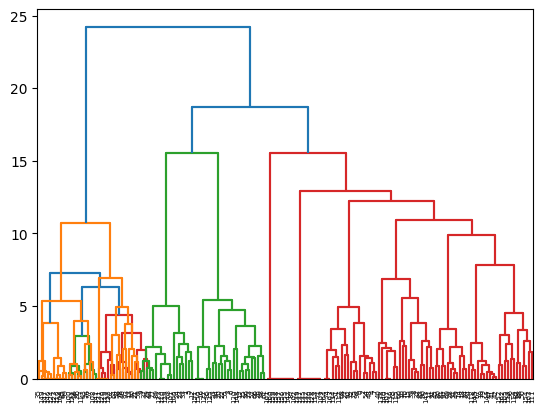

In [6]:
# sort t1l synapse df by cosine similarity 

t1l_conn_mat, t1l_sim_mat, t1l_pre_ids_ordered, t1l_post_ids_ordered = reorder_by_cosine(t1l_synapse_df, has_soma=False)

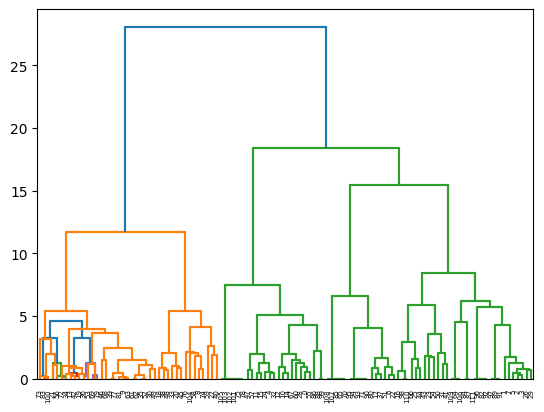

In [7]:
# sort t2r synapse df by cosine similarity 

t2r_conn_mat, t2r_sim_mat, t2r_pre_ids_ordered, t2r_post_ids_ordered = reorder_by_cosine(t2r_synapse_df, has_soma=False)

In [8]:
# convert seg ids to descriptive cell type names 

t1l_names = []
pre_ids_ordered_names = []

for idx in t1l_pre_ids_ordered: 
        
    if idx in feco_df_all['pt_root_id'].tolist():
        cell_id = feco_df_all.cell_type[feco_df_all.pt_root_id == idx].tolist()
        num = feco_df_all.id[feco_df_all.pt_root_id == idx].tolist()
        name_temp = cell_id[0] + str(num)
        t1l_names.append(name_temp)  

    else: 
        name_temp = 'uk' 
        t1l_names.append(name_temp)                          

t2r_names = []
pre_ids_ordered_names = []

for idx in t2r_pre_ids_ordered: 
        
    if idx in feco_df_all['pt_root_id'].tolist():
        cell_id = feco_df_all.cell_type[feco_df_all.pt_root_id == idx].tolist()
        num = feco_df_all.id[feco_df_all.pt_root_id == idx].tolist()
        name_temp = cell_id[0] + str(num)
        t2r_names.append(name_temp)  

    else: 
        name_temp = 'uk' 
        t2r_names.append(name_temp)  
    

<Figure size 640x480 with 0 Axes>

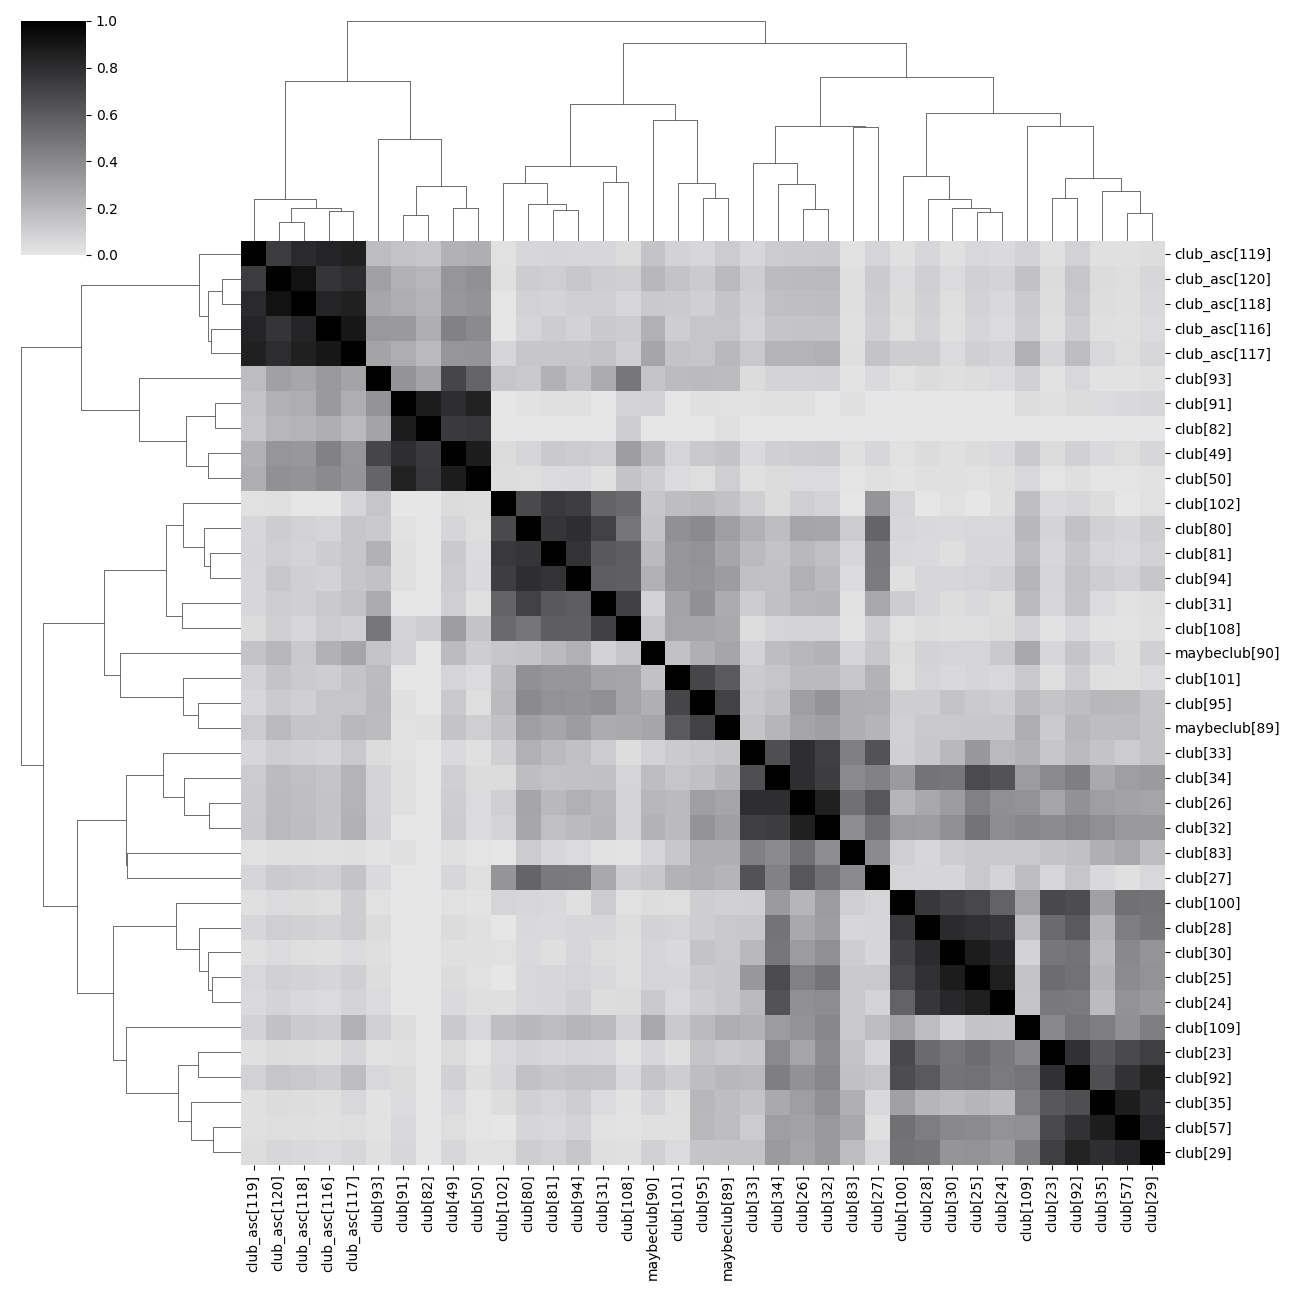

In [9]:
# Figure 3A-i (T1L)

# plot cosine similarity matrix (T1L)

fig = plt.figure()
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True) #black and white colormap 
test = sns.clustermap(t1l_sim_mat, xticklabels = t1l_names, yticklabels = t1l_names, 
               cmap = cmap, figsize = [13,13])
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.rcParams.update({'font.size': 5})
# plt.savefig('t1l_clustered_cosine_sim.pdf', bbox_inches='tight', dpi = 300)
plt.show()


<Figure size 640x480 with 0 Axes>

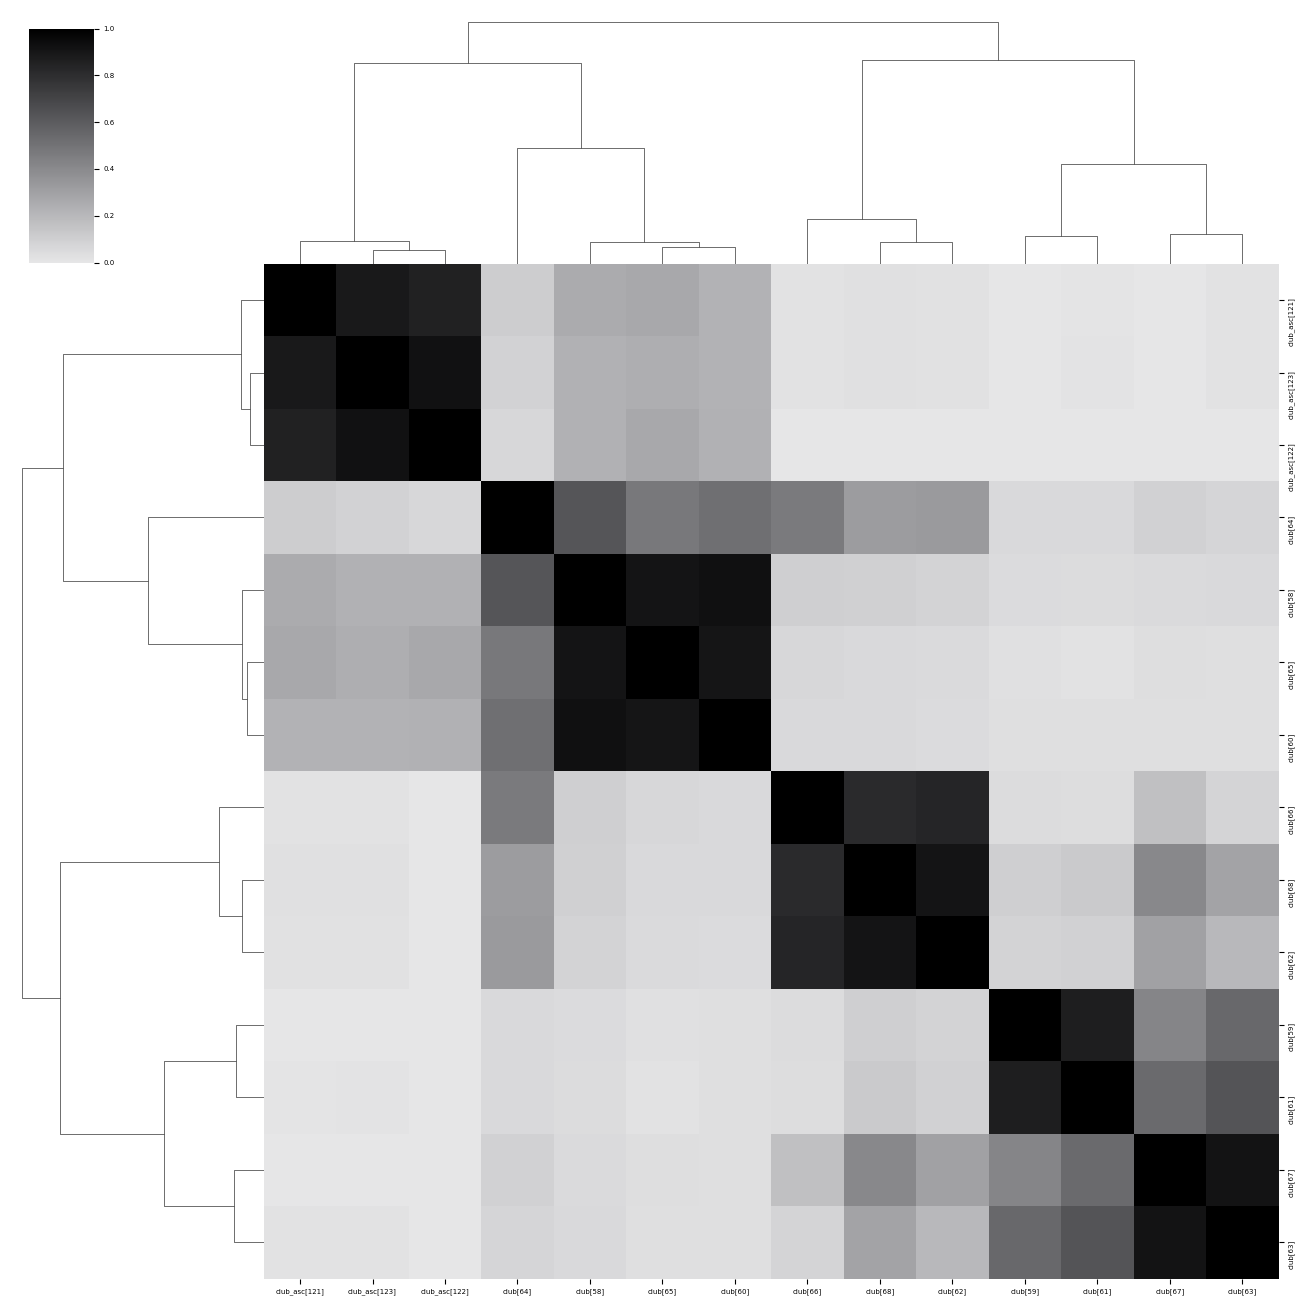

In [10]:
#Figure 3A-ii (T2R)  
# plot cosine similarity matrix (T2R)

fig = plt.figure()

test2 = sns.clustermap(t2r_sim_mat, xticklabels = t2r_names, yticklabels = t2r_names, 
               cmap = cmap, figsize = [13,13])
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.rcParams.update({'font.size': 5})
# plt.savefig('t2r_clustered_cosine_sim.pdf', bbox_inches='tight', dpi = 300)
plt.show()

In [11]:
# Figure 3D - cosine simlarity matrix of  T1L and T2R 
# get downstream connections for T1L and T2R club neurons combined 
upstream = False
syn_thresh = 4

# input t1l_clubs 
inputs = t1l_club_df.pt_root_id.tolist() + t2r_club_df.pt_root_id.tolist() 
if upstream == True:
    syn_df = client.materialize.synapse_query(post_ids = inputs)
else:
    syn_df = client.materialize.synapse_query(pre_ids = inputs)
    
# filter out connections with <4 synapses 
from my_functions import *
t1l_t2r_synapse_df = filt_syn_df(syn_df, syn_thresh)


In [12]:
# constrain synapse dataframe to downstream partners shared between t1l and t2r clubs 

#query t1l and t2r postsynaptic partner lists for overlap 
lst1 = t1l_synapse_df.post_pt_root_id.unique().tolist()
lst2 = t2r_synapse_df.post_pt_root_id.unique().tolist() 

lst3 = [value for value in lst1 if value in lst2]

    
start_df = t1l_t2r_synapse_df
prepost = "post"


if prepost == "pre":
    filtered_synapse_df = start_df[start_df['pre_pt_root_id'].isin(lst3)]
    
if prepost == "post":
    filtered_synapse_df = start_df[start_df['post_pt_root_id'].isin(lst3)]
      
filtered_synapse_df

,id,created,superceded_id,valid,score,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position
14,42183034,2022-11-17 14:28:59.843347+00:00,NaN,t,15,73469368579010627,648518346475974370,73469368579026705,648518346473084516,"[41373, 131247, 3168]","[41383, 131267, 3166]"
18,42183046,2022-11-17 14:28:59.843347+00:00,NaN,t,30,73469368578930875,648518346475974370,73469368578947896,648518346499724869,"[41379, 131073, 3129]","[41399, 131079, 3130]"
20,42183051,2022-11-17 14:28:59.843347+00:00,NaN,t,28,73469368579041402,648518346475974370,73469368579034023,648518346499724869,"[41379, 131233, 3168]","[41407, 131233, 3167]"
26,42183081,2022-11-17 14:28:59.843347+00:00,NaN,t,27,73469299859433359,648518346475974370,73469368578933389,648518346499724869,"[41427, 131067, 3124]","[41447, 131095, 3124]"
28,42183071,2022-11-17 14:28:59.843347+00:00,NaN,t,68,73469368578892556,648518346475974370,73469368578921742,648518346517652772,"[41411, 131075, 3120]","[41437, 131095, 3120]"
...,...,...,...,...,...,...,...,...,...,...,...
22912,38295999,2022-11-17 14:28:59.843347+00:00,NaN,t,40,73398999700694626,648518346478167277,73398999700715233,648518346474435437,"[40337, 131329, 2927]","[40371, 131315, 2927]"
22918,38498014,2022-11-17 14:28:59.843347+00:00,NaN,t,31,73328631090482508,648518346494998706,73328631090275473,648518346500711093,"[38703, 131347, 3087]","[38687, 131385, 3088]"
22919,38295961,2022-11-17 14:28:59.843347+00:00,NaN,t,16,73398999700666571,648518346499960531,73398999700659481,648518346498434097,"[40295, 131969, 2899]","[40285, 132003, 2900]"
22920,38295967,2022-11-17 14:28:59.843347+00:00,NaN,t,20,73398999700643868,648518346499960531,73398999700624518,648518346498434097,"[40263, 131885, 2891]","[40301, 131899, 2891]"


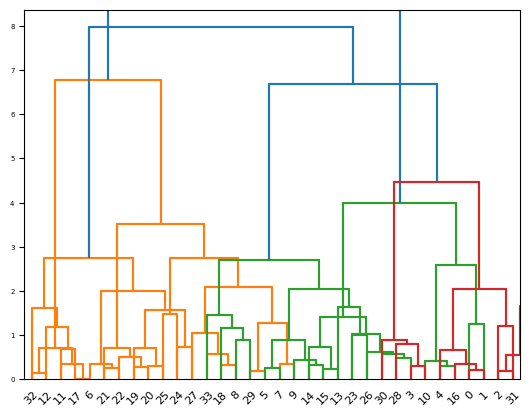

In [13]:
# sort dataframe by cosine similarity 
conn_mat, sim_mat, pre_ids_ordered, post_ids_ordered = reorder_by_cosine(filtered_synapse_df, has_soma=False)


In [14]:
# convert segIDs to descriptive cell type names 

names = []

for idx in pre_ids_ordered: 
        
    if idx in feco_df_all['pt_root_id'].tolist():
        cell_id = feco_df_all.cell_type[feco_df_all.pt_root_id == idx].tolist()
        num = feco_df_all.id[feco_df_all.pt_root_id == idx].tolist()
        name_temp = cell_id[0] + str(num)
        names.append(name_temp)  

    else: 
        name_temp = 'uk' 
        names.append(name_temp)                          
    

<Figure size 640x480 with 0 Axes>

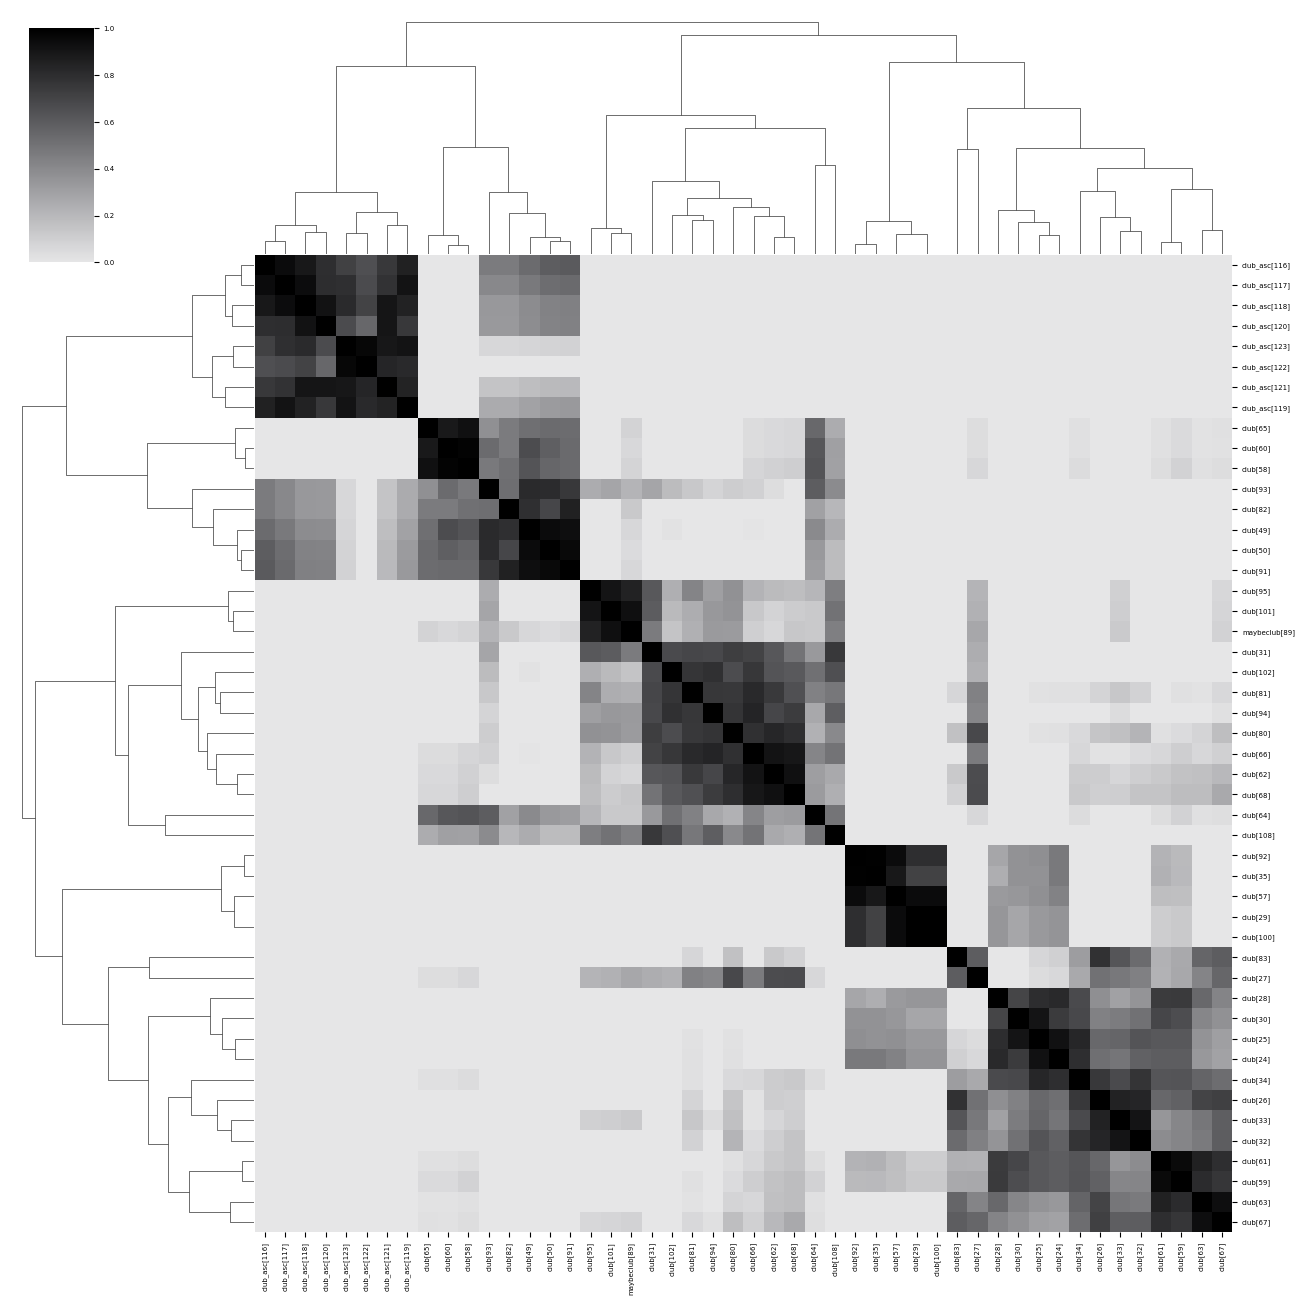

In [15]:
#Figure 3E plot cosine similarity matrix of T1L and T2R club neurons combined 
fig = plt.figure()

test3 = sns.clustermap(sim_mat, xticklabels = names, yticklabels = names,cmap = cmap, figsize = [13,13])
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.rcParams.update({'font.size': 5})
# plt.savefig('t1l_t2r_clustered_cosine_sim.pdf', bbox_inches='tight', dpi = 300)
plt.show()

In [16]:
# quantify % input from each club cluster group onto downstream partners and color-code by group 
# club neurons grouped by cosine ordered cluster 

dorsal_club_t1l = [648518346488912397,
648518346503137403,
648518346499541854,
648518346509233018,
648518346492002415,
648518346494263154,
648518346511235381,
648518346500706739,
648518346531374106,
648518346481703327]

medial_club_t1l = [648518346517527332,
648518346531363354,
648518346499840723,
648518346488978410,
648518346484528131,
648518346486545841,
648518346490136273,
648518346488054046,
648518346524142085]

ventral_club_t1l = [648518346495414351,
648518346481068634,
648518346522179866,
648518346495765904,
648518346511819888,
648518346514007065,
648518346514428359,
648518346494038560,
648518346498554608,
648518346497858151,
648518346482976742,
648518346477963245,
648518346524144133,
648518346472537865,
648518346487705300,
648518346499385438,
648518346503767201,
648518346499893315]

# T2R 
dorsal_club_t2r = [648518346483806357,
648518346478167277,
648518346492356223,
648518346475974370,
648518346488045079,
648518346499960531,
648518346518565462]

medial_club_t2r = [648518346493225392,
648518346474234477,
648518346502655814]

ventral_club_t2r = [648518346495993163,
648518346492913070,
648518346477811470,
648518346494998706]

In [17]:
# quantify distribution of inputs from dorsal, medial, or ventral clubs onto a postsynaptic partner 

t1l_syn = t1l_synapse_df.groupby(['pre_pt_root_id','post_pt_root_id'])['pre_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=["number_of_synapses"]).sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
t2r_syn = t2r_synapse_df.groupby(['pre_pt_root_id','post_pt_root_id'])['pre_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=["number_of_synapses"]).sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)

combined_df = pd.concat([t1l_syn, t2r_syn])
post_ids = combined_df.post_pt_root_id.unique().tolist() 

total_synapses = [] 
dorsal_input_t1 = [] 
medial_input_t1 = [] 
ventral_input_t1 = [] 
dorsal_input_t2 = [] 
medial_input_t2 = [] 
ventral_input_t2 = [] 
cell_type = [] 
classification = [] 

for idx in post_ids: 
    club_input_df = combined_df[combined_df.post_pt_root_id == idx]
    dorsal_input_t1.append(np.sum(club_input_df[club_input_df.pre_pt_root_id.isin(dorsal_club_t1l)].number_of_synapses))
    medial_input_t1.append(np.sum(club_input_df[club_input_df.pre_pt_root_id.isin(medial_club_t1l)].number_of_synapses))
    ventral_input_t1.append(np.sum(club_input_df[club_input_df.pre_pt_root_id.isin(ventral_club_t1l)].number_of_synapses))
    dorsal_input_t2.append(np.sum(club_input_df[club_input_df.pre_pt_root_id.isin(dorsal_club_t2r)].number_of_synapses))
    medial_input_t2.append(np.sum(club_input_df[club_input_df.pre_pt_root_id.isin(medial_club_t2r)].number_of_synapses))
    ventral_input_t2.append(np.sum(club_input_df[club_input_df.pre_pt_root_id.isin(ventral_club_t2r)].number_of_synapses))

    total_synapses.append(np.sum(club_input_df.number_of_synapses))
    
    if idx in downstream_feco_df_all.pt_root_id.unique().tolist(): 
        cell_type.append(downstream_feco_df_all[downstream_feco_df_all.pt_root_id == idx].cell_type.tolist()[0]) 
        classification.append(downstream_feco_df_all[downstream_feco_df_all.pt_root_id == idx].classification_system.tolist()[0]) 

    else: 
        cell_type.append('uk')
        classification.append('uk')
        
club_input_breakdown = pd.DataFrame() 
club_input_breakdown['post_pt_root_id'] = post_ids  

club_input_breakdown['t1l_dorsal'] = dorsal_input_t1
club_input_breakdown['t2r_dorsal'] = dorsal_input_t2

club_input_breakdown['t1l_medial'] = medial_input_t1
club_input_breakdown['t2r_medial'] = medial_input_t2

club_input_breakdown['t1l_ventral'] = ventral_input_t1
club_input_breakdown['t2r_ventral'] = ventral_input_t2

club_input_breakdown['cell_type'] = cell_type
club_input_breakdown['classification'] = classification 

# get rid of fragments 

club_input_breakdown = club_input_breakdown[club_input_breakdown.classification != 'fragment']

In [ ]:
# quantify if a postsynaptic partner received biased input from one cosine ordered group over another 

total_synapses = [] 
t1_dorsal_synapses = [] 
t1_medial_synapses = [] 
t1_ventral_synapses = [] 

t2_dorsal_synapses = [] 
t2_medial_synapses = [] 
t2_ventral_synapses = [] 


for idx in club_input_breakdown.post_pt_root_id.tolist(): 
    filler_df = club_input_breakdown[club_input_breakdown.post_pt_root_id == idx]
    total_synapses.append(filler_df.t1l_dorsal.tolist()[0] + filler_df.t2r_dorsal.tolist()[0] + filler_df.t1l_medial.tolist()[0] + filler_df.t2r_medial.tolist()[0] + filler_df.t1l_ventral.tolist()[0] + filler_df.t2r_ventral.tolist()[0])
    t1_dorsal_synapses.append(filler_df.t1l_dorsal.tolist()[0])
    t1_medial_synapses.append(filler_df.t1l_medial.tolist()[0])
    t1_ventral_synapses.append(filler_df.t1l_ventral.tolist()[0]) 
    
    t2_dorsal_synapses.append(filler_df.t2r_dorsal.tolist()[0])
    t2_medial_synapses.append(filler_df.t2r_medial.tolist()[0])
    t2_ventral_synapses.append(filler_df.t2r_ventral.tolist()[0])


ton_pref = pd.DataFrame() 
ton_pref['post_pt_root_id'] = post_ids
ton_pref['cell_type'] = cell_type 
ton_pref['classification'] = classification
ton_pref['total_synapses'] = total_synapses
ton_pref['t1_dorsal_synapses'] = t1_dorsal_synapses
ton_pref['t1_medial_synapses'] = t1_medial_synapses
ton_pref['t1_ventral_synapses'] = t1_ventral_synapses
ton_pref['t2_dorsal_synapses'] = t2_dorsal_synapses
ton_pref['t2_medial_synapses'] = t2_medial_synapses
ton_pref['t2_ventral_synapses'] = t2_ventral_synapses

ValueError: Length of values (208) does not match length of index (243)

In [ ]:
# convert number of synapses to fraction of input coming from dorsal, medial, or ventral club groups 

t1l_post = list(set(t1l_syn.post_pt_root_id.unique().tolist()) - set(t2r_syn.post_pt_root_id.unique().tolist()))
t2r_post = list(set(t2r_syn.post_pt_root_id.unique().tolist()) - set(t1l_syn.post_pt_root_id.unique().tolist()))
t1l_t2r_post = filtered_synapse_df.post_pt_root_id.unique().tolist()
t1l_t2r_only = ton_pref[ton_pref.post_pt_root_id.isin(t1l_t2r_post)]


t1l_only = ton_pref[ton_pref.post_pt_root_id.isin(t1l_post)]
t1l_only = t1l_only[t1l_only.classification != 'fragment']
t2r_only = ton_pref[ton_pref.post_pt_root_id.isin(t2r_post)]
t2r_only = t2r_only[t2r_only.classification != 'fragment']
t1l_t2r_only = ton_pref[ton_pref.post_pt_root_id.isin(t1l_t2r_post)]

t1l_only['dorsal_synapses'] = t1l_only['t1_dorsal_synapses']/t1l_only['total_synapses']
t1l_only['medial_synapses'] = t1l_only['t1_medial_synapses']/t1l_only['total_synapses']
t1l_only['ventral_synapses'] = t1l_only['t1_ventral_synapses']/t1l_only['total_synapses']

t2r_only['dorsal_synapses'] = t2r_only['t2_dorsal_synapses']/t2r_only['total_synapses']
t2r_only['medial_synapses'] = t2r_only['t2_medial_synapses']/t2r_only['total_synapses']
t2r_only['ventral_synapses'] = t2r_only['t2_ventral_synapses']/t2r_only['total_synapses']

t1l_t2r_only['t1_dorsal_synapses'] = t1l_t2r_only['t1_dorsal_synapses']/t1l_t2r_only['total_synapses']
t1l_t2r_only['t1_medial_synapses'] = t1l_t2r_only['t1_medial_synapses']/t1l_t2r_only['total_synapses']
t1l_t2r_only['t1_ventral_synapses'] = t1l_t2r_only['t1_ventral_synapses']/t1l_t2r_only['total_synapses']

t1l_t2r_only['t2_dorsal_synapses'] = t1l_t2r_only['t2_dorsal_synapses']/t1l_t2r_only['total_synapses']
t1l_t2r_only['t2_medial_synapses'] = t1l_t2r_only['t2_medial_synapses']/t1l_t2r_only['total_synapses']
t1l_t2r_only['t2_ventral_synapses'] = t1l_t2r_only['t2_ventral_synapses']/t1l_t2r_only['total_synapses']

t1l_t2r_only['dorsal_synapses'] = (t1l_t2r_only['t1_dorsal_synapses'] + t1l_t2r_only['t2_dorsal_synapses'])
t1l_t2r_only['medial_synapses'] = (t1l_t2r_only['t1_medial_synapses'] + t1l_t2r_only['t2_medial_synapses'])
t1l_t2r_only['ventral_synapses'] = (t1l_t2r_only['t1_ventral_synapses'] + t1l_t2r_only['t2_ventral_synapses'])

t1l_t2r_only = t1l_t2r_only.sort_values(by = ['dorsal_synapses', 'medial_synapses', 'ventral_synapses'])

In [ ]:
# plot bar plots of club group inputs onto postsynaptic partners 

t1l_t2r_only = t1l_t2r_only.sort_values(by = ['ventral_synapses', 'medial_synapses', 'dorsal_synapses'])

colors = ["#CC6699","#83c54d","#36c6f4"]
cmap = sns.set_palette(sns.color_palette(colors))
ax = t1l_only[['post_pt_root_id', 'ventral_synapses', 'medial_synapses', 'dorsal_synapses']].sort_values(by=['ventral_synapses', 'medial_synapses', 'dorsal_synapses']).plot(x='post_pt_root_id',
                                           kind='bar',
                                           stacked=True, 
                                           figsize = [24, 12], 
                                           fontsize = 25,
                                           width = 1,
                                           edgecolor = 'white',
                                           linewidth = 5)
ax.set_xticklabels(t1l_only.sort_values(by=['ventral_synapses', 'medial_synapses', 'dorsal_synapses']).cell_type)
sns.set_palette(sns.color_palette("Set1"))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize = 25)
plt.ylabel('input synapse fraction', fontsize = 25)
plt.xlabel('postsynaptic neurons', fontsize = 25)
# plt.savefig('t1l_post_club_input.pdf', bbox_inches='tight', dpi = 300)

plt.show()


# colors = ["#FF6B1E","#3B8500","#00648D"]
colors = ["#8E4B6C","#688E49","#56A6BF"]

#"#d1b26f"
cmap = sns.set_palette(sns.color_palette(colors))
ax = t2r_only[['post_pt_root_id', 'ventral_synapses', 'medial_synapses', 'dorsal_synapses']].sort_values(by=['ventral_synapses', 'medial_synapses', 'dorsal_synapses']).plot(x='post_pt_root_id',
                                           kind='bar',
                                           stacked=True, 
                                           figsize = [24, 12], 
                                           fontsize = 25,
                                           width = 1,
                                           edgecolor = 'white',
                                           linewidth = 10)
ax.set_xticklabels(t2r_only.sort_values(by=['ventral_synapses', 'medial_synapses', 'dorsal_synapses']).cell_type)
sns.set_palette(sns.color_palette("Set1"))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize = 25)
plt.ylabel('input synapse fraction', fontsize = 25)
plt.xlabel('postsynaptic neurons', fontsize = 25)
# plt.savefig('t2r_post_club_input.pdf', bbox_inches='tight', dpi = 300)

plt.show()

colors = ["#CC6699", "#8E4B6C", "#83c54d","#688E49", "#36c6f4", "#56A6BF"]
#"#d1b26f"
cmap = sns.set_palette(sns.color_palette(colors))
ax = t1l_t2r_only[['post_pt_root_id', 't1_ventral_synapses', 't2_ventral_synapses', 't1_medial_synapses', 't2_medial_synapses', 't1_dorsal_synapses', 't2_dorsal_synapses']].plot(x='post_pt_root_id',
                                           kind='bar',
                                           stacked=True, 
                                           figsize = [24, 12], 
                                           fontsize = 25,
                                           width = 1,
                                           edgecolor = 'white',
                                           linewidth = 10)
ax.set_xticklabels(t1l_t2r_only.cell_type)
sns.set_palette(sns.color_palette("Set1"))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize = 25)
plt.ylabel('input synapse fraction', fontsize = 25)
plt.xlabel('postsynaptic neurons', fontsize = 25)
# plt.savefig('t1l_t2r_post_club_input.pdf', bbox_inches='tight', dpi = 300)

plt.show()